In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

import time

tempoInicial = time.time()

In [2]:
def N(n):
    return 1*1./np.sqrt(np.sqrt(np.pi)*2**n*factorial(n))

def psix(n, x):
    Hn=hermite(n)
    Px = N(n)*Hn(x)*np.exp(-0.5*x**2)
    return Px

def psixt(n, x, t):
    Hn=hermite(n)
    a = complex(0,1)
    Pxt = N(n)*Hn(x)*np.exp(-0.5*x**2)*np.exp(-a*(n+1/2)*t*np.pi)
    return Pxt

In [3]:
def CrankNicolson(M, O = 0, L = 1, T = 0.5):
    N = 500 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = 3.141111111111111111111111111
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)

    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    V = 1/2*m*w**2*xs**2

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()
    
    #Obtenção da matriz psi (Ela acumulará para o psi futuro)
    ps = np.zeros((M, N))
    psi_c = np.zeros((M, N))

    #Condição inicial
    ps[:,0] = 0.80 * psix(0, xs) + 0.60 * psix(1, xs) #A primeira coluna da matriz terá a equação inicial, em todas as posições
    psi_c = ps.astype(complex)
    #For para o acúmulo de resultados
    for k in range(1,N):
        b = np.matmul(matrizB, np.array(psi_c[0:M, k-1])) #Multiplicação de arrays já que houve uma conversão anterior
        psi_c[0:M, k] = np.linalg.solve(matrizA, b) #Matlab: x = A\b
        #plt.plot(xs, np.absolute(psi_c[0:M, k])**2)
    return psi_c

In [4]:
def multMatrizes(M, us, O = -5, L = 5, T = 10):
    N = 500 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = 3.141111111111111111111111111
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)
    
    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    #V = us #V(x,u(t))
    V = 1/2*m*w**2*xs**2+us

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()

    return np.matmul(np.linalg.inv(matrizA), matrizB)

In [5]:
# Gradiente e função objetivo

def ExactSolution(M, T = 5, L = 5):
    N = 500

    xs = np.linspace(-5, L, M)
    ts = np.linspace(0, N/10, T)
    
    psiExato = np.zeros((M, N)).astype(complex)
    r=0
    for i in np.arange(-5, 5, 0.1):
        for j in np.arange(0, 10, 0.1):
            psiExato[r][int(j*10)] = 1/np.sqrt(2)*psixt(0,i,j)+1/np.sqrt(2)*psixt(1,i,j)
        r+=1
    return psiExato

def Objetivo(x, y, psi, psiExato):
    A = np.zeros((500,500))
    B = np.zeros((500,500))
    A = multMatrizes(M = 500, us = x[0])
    B = multMatrizes(M = 500, us = x[1])
    return ((np.linalg.norm(np.array(psiExato[0:500, y])-np.array(psi)))**2+
            (np.linalg.norm(np.array(psiExato[0:500, y+1])-np.array(np.matmul(A,psi))))**2+
            (np.linalg.norm(np.array(psiExato[0:500, y+2])-np.array(np.matmul(np.matmul(B,A),psi))))**2)

In [6]:
import random

psi = np.zeros((500,500))
psi_f = np.zeros((500,500))
psi_g = psi_f.astype(complex)
psi = CrankNicolson(M = 500, O = -5, L = 5, T = 10)
psiExato = ExactSolution(M = 500)

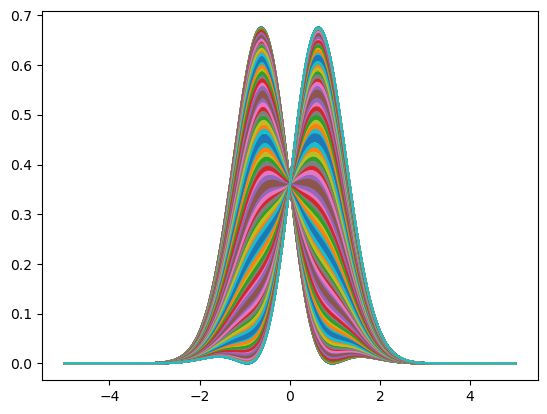

In [7]:
xs = np.linspace(-5,5,500)
plt.plot(xs, np.absolute(psi[0:500,0:500])**2)

[-0.6945112724720932, -0.3574597505481556]
Iteração: 1
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 85892.14697408296
       x: [-3.895e+02  3.207e+01]
     nit: 12
     jac: [ 0.000e+00  0.000e+00]
    nfev: 144
    njev: 48
---------------
[-389.47700573081266, 0.8308018725881752]
Iteração: 2
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 82400.57654165066
       x: [ 3.208e+01  3.372e+01]
     nit: 13
     jac: [ 0.000e+00  0.000e+00]
    nfev: 150
    njev: 50
---------------
[32.0763991065394, 1.58449195065666]
Iteração: 3
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 81988.77001351188
       x: [ 3.370e+01  3.467e+01]
     nit: 10
     jac: [ 0.000e+00 -9.766e-04]
    nfev: 195
    njev: 61
---------------
[33.69904708723763, 4.8478711124031175]
Iteração: 4
 message: Desired error not necessarily achieved due to precision loss.
 success: Fa

Iteração: 29
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 82951.34171294836
       x: [ 3.217e+01  2.966e+01]
     nit: 8
     jac: [-9.766e-04 -9.766e-04]
    nfev: 212
    njev: 67
---------------
[32.165301317440395, 1.4388413181456272]
Iteração: 30
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 83620.72656207526
       x: [ 2.969e+01  2.569e+01]
     nit: 10
     jac: [ 0.000e+00  0.000e+00]
    nfev: 114
    njev: 38
---------------
[29.688686072538644, 0.9625133808945154]
Iteração: 31
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 84368.24332068925
       x: [ 2.568e+01  1.937e+01]
     nit: 10
     jac: [ 0.000e+00  0.000e+00]
    nfev: 123
    njev: 41
---------------
[25.67946326056898, 1.204240326387903]
Iteração: 32
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 85136.787683

Iteração: 58
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 85137.07436119701
       x: [ 9.401e+00  1.936e+01]
     nit: 10
     jac: [ 2.930e-03  1.953e-03]
    nfev: 384
    njev: 124
---------------
[9.400766095188821, 1.0657102019005515]
Iteração: 59
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 84368.8625724324
       x: [ 1.937e+01  2.570e+01]
     nit: 9
     jac: [ 3.906e-03  1.953e-03]
    nfev: 225
    njev: 71
---------------
[19.371902647138114, 1.181610138540905]
Iteração: 60
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 83621.6137296329
       x: [ 2.571e+01  2.967e+01]
     nit: 12
     jac: [ 0.000e+00  0.000e+00]
    nfev: 120
    njev: 40
---------------
[25.708498253605455, -2.8613047672216894]
Iteração: 61
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status:

Iteração: 86
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 81733.04282470295
       x: [ 3.506e+01  3.461e+01]
     nit: 8
     jac: [ 0.000e+00  0.000e+00]
    nfev: 120
    njev: 40
---------------
[35.0577109460601, -2.119967324077139]
Iteração: 87
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 81986.63331481046
       x: [ 3.460e+01  3.373e+01]
     nit: 14
     jac: [ 0.000e+00  0.000e+00]
    nfev: 177
    njev: 59
---------------
[34.60384177085287, -2.2342317860885696]
Iteração: 88
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 82398.54425687445
       x: [ 3.369e+01  3.221e+01]
     nit: 10
     jac: [-5.859e-03 -1.953e-03]
    nfev: 138
    njev: 46
---------------
[33.6891322948296, 1.193722437256004]
Iteração: 89
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 82951.919421179

Iteração: 114
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 74849.9999979962
       x: [ 1.947e+01 -7.182e-01]
     nit: 1
     jac: [ 0.000e+00  0.000e+00]
    nfev: 36
    njev: 12
---------------
[19.47375672892578, 2.0977590442641914]
Iteração: 115
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999799617
       x: [ 1.947e+01  2.098e+00]
     nit: 0
     jac: [ 9.766e-04  9.766e-04]
    nfev: 140
    njev: 43
---------------
[19.47375672892578, 4.601352646194746]
Iteração: 116
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999799617
       x: [ 1.947e+01  4.601e+00]
     nit: 1
     jac: [ 0.000e+00  1.953e-03]
    nfev: 149
    njev: 46
---------------
[19.473550382795512, -2.580062901343181]
Iteração: 117
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 

Iteração: 142
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999799684
       x: [ 1.947e+01 -1.544e+00]
     nit: 0
     jac: [-1.953e-03  0.000e+00]
    nfev: 91
    njev: 27
---------------
[19.474131270250098, -1.4639689042367454]
Iteração: 143
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999799686
       x: [ 1.947e+01 -1.464e+00]
     nit: 1
     jac: [ 9.766e-04  9.766e-04]
    nfev: 163
    njev: 51
---------------
[19.47414104785087, 3.8927366571602064]
Iteração: 144
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999799689
       x: [ 1.947e+01  3.893e+00]
     nit: 2
     jac: [ 9.766e-04  0.000e+00]
    nfev: 30
    njev: 10
---------------
[19.474153611107816, -3.9443636746784403]
Iteração: 145
 message: Desired error not necessarily achieved due to precision los

Iteração: 169
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 74849.99999799751
       x: [ 1.947e+01 -2.955e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00]
    nfev: 117
    njev: 39
---------------
[19.473989721052835, -4.466968637641089]
Iteração: 170
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999799754
       x: [ 1.947e+01 -4.467e+00]
     nit: 0
     jac: [ 1.953e-03  1.953e-03]
    nfev: 153
    njev: 47
---------------
[19.473989721052835, 2.687212058846155]
Iteração: 171
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999799751
       x: [ 1.947e+01  2.687e+00]
     nit: 1
     jac: [ 4.883e-03  2.930e-03]
    nfev: 159
    njev: 49
---------------
[19.4739940865168, 0.9017621163056955]
Iteração: 172
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status

Iteração: 197
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999799818
       x: [ 1.947e+01  4.877e+00]
     nit: 1
     jac: [ 1.953e-03  0.000e+00]
    nfev: 18
    njev: 6
---------------
[19.47399530317683, 1.532080389112065]
Iteração: 198
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999799818
       x: [ 1.947e+01  1.532e+00]
     nit: 2
     jac: [ 1.953e-03  0.000e+00]
    nfev: 144
    njev: 42
---------------
[19.474047432664293, -0.39078015301987]
Iteração: 199
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 74849.99999799822
       x: [ 1.947e+01 -3.908e-01]
     nit: 0
     jac: [ 0.000e+00  0.000e+00]
    nfev: 3
    njev: 1
---------------
[19.474047432664293, -2.012565362725993]
Iteração: 200
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
 

Iteração: 225
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999799886
       x: [ 1.947e+01  2.568e+00]
     nit: 2
     jac: [ 0.000e+00  9.766e-04]
    nfev: 69
    njev: 23
---------------
[19.47429144213465, 0.48591806057801357]
Iteração: 226
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 74849.9999979989
       x: [ 1.947e+01  4.859e-01]
     nit: 2
     jac: [ 0.000e+00  0.000e+00]
    nfev: 48
    njev: 16
---------------
[19.473791009460356, 0.30865778924744447]
Iteração: 227
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999799895
       x: [ 1.947e+01  3.087e-01]
     nit: 0
     jac: [-1.953e-03  9.766e-04]
    nfev: 146
    njev: 45
---------------
[19.473791009460356, -4.1702364245862436]
Iteração: 228
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  stat

Iteração: 253
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999799949
       x: [ 1.947e+01 -2.709e+00]
     nit: 1
     jac: [-9.766e-04  0.000e+00]
    nfev: 136
    njev: 42
---------------
[19.47369755375955, -3.1529930016128658]
Iteração: 254
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999799953
       x: [ 1.947e+01 -3.153e+00]
     nit: 0
     jac: [-9.766e-04 -9.766e-04]
    nfev: 72
    njev: 21
---------------
[19.47369755375955, -4.878694309269202]
Iteração: 255
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999799952
       x: [ 1.947e+01 -4.879e+00]
     nit: 1
     jac: [ 9.766e-04  9.766e-04]
    nfev: 24
    njev: 8
---------------
[19.473695988030773, 4.039756508366896]
Iteração: 256
 message: Desired error not necessarily achieved due to precision loss.
 

Iteração: 281
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 74849.99999800033
       x: [ 1.947e+01  2.822e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00]
    nfev: 33
    njev: 11
---------------
[19.474295923932306, 0.4094378242993333]
Iteração: 282
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800035
       x: [ 1.947e+01  4.094e-01]
     nit: 1
     jac: [ 0.000e+00 -1.953e-03]
    nfev: 101
    njev: 30
---------------
[19.474444239535156, -1.34043506449785]
Iteração: 283
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800036
       x: [ 1.947e+01 -1.340e+00]
     nit: 2
     jac: [ 1.953e-03  0.000e+00]
    nfev: 178
    njev: 56
---------------
[19.47445119472017, -3.9982196349031085]
Iteração: 284
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  statu

Iteração: 309
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800095
       x: [ 1.947e+01 -2.740e+00]
     nit: 1
     jac: [ 1.953e-03 -2.930e-03]
    nfev: 33
    njev: 11
---------------
[19.474689643782014, -1.034914002752605]
Iteração: 310
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800102
       x: [ 1.947e+01 -1.035e+00]
     nit: 0
     jac: [-9.766e-04  0.000e+00]
    nfev: 112
    njev: 34
---------------
[19.474689643782014, -1.7894109101978506]
Iteração: 311
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800099
       x: [ 1.947e+01 -1.789e+00]
     nit: 2
     jac: [ 1.953e-03  9.766e-04]
    nfev: 155
    njev: 48
---------------
[19.474786995056206, 1.337092609890254]
Iteração: 312
 message: Desired error not necessarily achieved due to precision los

Iteração: 336
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800147
       x: [ 1.947e+01 -4.640e+00]
     nit: 1
     jac: [ 0.000e+00 -1.953e-03]
    nfev: 229
    njev: 71
---------------
[19.474683103893852, 4.213818681013436]
Iteração: 337
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 74849.99999800153
       x: [ 1.947e+01  4.214e+00]
     nit: 1
     jac: [ 0.000e+00  0.000e+00]
    nfev: 36
    njev: 12
---------------
[19.47468310392463, 2.7051096975046205]
Iteração: 338
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800156
       x: [ 1.947e+01  2.705e+00]
     nit: 0
     jac: [ 2.930e-03  1.953e-03]
    nfev: 99
    njev: 29
---------------
[19.47468310392463, -2.5833453312076515]
Iteração: 339
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status:

Iteração: 364
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800217
       x: [ 1.947e+01  3.712e+00]
     nit: 1
     jac: [ 4.883e-03  9.766e-04]
    nfev: 95
    njev: 28
---------------
[19.47430468475138, -2.7870240023297024]
Iteração: 365
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800217
       x: [ 1.947e+01 -2.787e+00]
     nit: 1
     jac: [ 1.953e-03 -1.953e-03]
    nfev: 116
    njev: 35
---------------
[19.474132760311548, -4.031730635479348]
Iteração: 366
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800218
       x: [ 1.947e+01 -4.032e+00]
     nit: 1
     jac: [ 9.766e-04 -9.766e-04]
    nfev: 162
    njev: 50
---------------
[19.474123992518052, -4.202468893069375]
Iteração: 367
 message: Optimization terminated successfully.
 success: True
  stat

Iteração: 392
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800284
       x: [ 1.947e+01  3.563e+00]
     nit: 0
     jac: [ 1.953e-03  0.000e+00]
    nfev: 72
    njev: 20
---------------
[19.47482105632912, 4.219231951352073]
Iteração: 393
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800284
       x: [ 1.947e+01  4.219e+00]
     nit: 2
     jac: [ 1.953e-03  3.906e-03]
    nfev: 187
    njev: 56
---------------
[19.474887201941826, -0.5478924637475799]
Iteração: 394
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800292
       x: [ 1.947e+01 -5.480e-01]
     nit: 1
     jac: [-4.883e-03  0.000e+00]
    nfev: 51
    njev: 17
---------------
[19.474887201941826, 4.245646173410542]
Iteração: 395
 message: Desired error not necessarily achieved due to precision loss.


Iteração: 420
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800364
       x: [ 1.947e+01  1.338e-03]
     nit: 1
     jac: [ 0.000e+00  9.766e-04]
    nfev: 129
    njev: 40
---------------
[19.474880174970718, -2.431688434757505]
Iteração: 421
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800365
       x: [ 1.947e+01 -2.432e+00]
     nit: 1
     jac: [ 1.953e-03  1.953e-03]
    nfev: 51
    njev: 17
---------------
[19.47487935959736, 2.5119830572228876]
Iteração: 422
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 74849.99999800367
       x: [ 1.947e+01  2.512e+00]
     nit: 1
     jac: [ 9.766e-04 -9.766e-04]
    nfev: 36
    njev: 12
---------------
[19.474879293783147, -3.471310991883759]
Iteração: 423
 message: Optimization terminated successfully.
 success: True
  status

KeyboardInterrupt: 

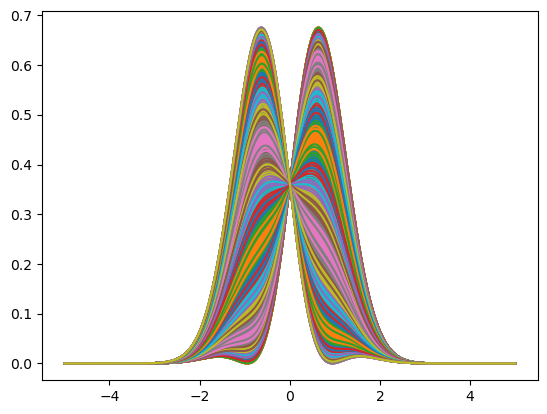

In [8]:
u1 = []
u2 = []
vetor = []
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
tempo = 0
xs = np.linspace(-5,5,500)
minimo = np.zeros((1, 500)).astype(complex)

while tempo < 498:
    print(u1)
    psi_g[0:500, tempo] = psi[0:500, tempo]
    plt.plot(xs, np.absolute(psi[0:500, tempo])**2)
    u2 = optimize.minimize(Objetivo, u1, args=(tempo, psi, psiExato), method='CG')
    print(f"Iteração: {tempo+1}")
    print(u2)
    print("---------------")
    minimo[0][tempo] = (u2.x[0])
    D = multMatrizes(M = 500, us = u2.x[0])
    psi = np.matmul(D, psi)
    tempo += 1
    u1 = []
    u1.append(u2.x[0])
    u1.append(random.uniform(-5, 5))

tempoFinal = time.time() - tempoIncial
print(tempoFinal)

In [ ]:
from matplotlib import animation
from matplotlib.animation import PillowWriter

def animate(i):
    xs = np.linspace(-5,5,100)
    ln1.set_data(xs, np.absolute(psi_g[0:100,i-1])**2)
    ln2.set_data(xs, np.absolute(psiExato[0:100,i-1])**2)
    time_text.set_text('$t=$'+'{:.1f}'.format(i/100))
    
fig, ax = plt.subplots(1, 1,figsize=(8,4))
ax.grid()
ln1, = plt.plot([], [], 'r-', lw=2, markersize=8, label='Origem')
ln2, = plt.plot([], [], 'b-', lw=2, markersize=8, label='Destino')
time_text = ax.text(0.85, 0.9, '', fontsize=15,
           bbox=dict(facecolor='white', edgecolor='black'))
ax.set_ylim(0, 1)
ax.set_xlim(-5,5)
title = ax.set_title('Resposta analítica')
ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.legend(loc='upper left')
ax.set_title('')
plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=100, interval=200)
ani.save('500x500.gif',writer='pillow',fps=10,dpi=100)